<a href="https://colab.research.google.com/github/fduque/TradingAgent_RegressionModels_SentimentAnalysis/blob/master/RegressionModels_and_Sentiment_Analysis_for_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stock Price Prediction based on price history (Yahoo Finance) and market sentiment analysis (Twitter)

#Part 1 - Price prediciton based on Yahoo finance historical data.

1.1: Pulling data from Yahoo Finance. 

# **Apple** was the company choosed for stock price prediction.
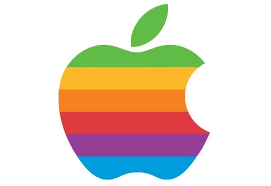

In [180]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix


start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-30,210.449997,207.199997,210.160004,208.740005,21143400.0,208.740005
2019-09-03,206.979996,204.220001,206.429993,205.699997,20023000.0,205.699997
2019-09-04,209.479996,207.320007,208.389999,209.190002,19188100.0,209.190002
2019-09-05,213.970001,211.509995,212.000000,213.279999,23913700.0,213.279999
2019-09-06,214.419998,212.509995,214.050003,213.259995,19350800.0,213.259995


1.2 Plotting Price Evolution:

Overview of stock price and rolling mean related 

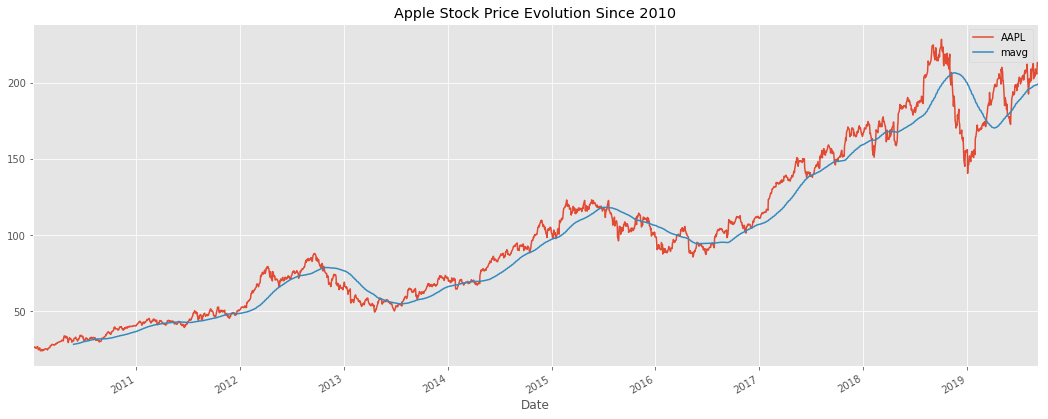

In [181]:
#Let’s start code out the Rolling Mean:
close_px = df['Adj Close']
#This will calculate the Moving Average for the last 100 windows (100 days) 
mavg = close_px.rolling(window=100).mean()

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(18, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.title('Apple Stock Price Evolution Since 2010')
plt.legend()

1.3 Applying Machine Learning.

Now we're going to apply five regression models. 

We're going to train them with historial data based on Adj_Close value.

Models used:
  Linear regression 
  Quadratic Regression 
  Quadratic Regression 
  KNN Regression
  Lasso Regression

1.3.1 - Preprocessing data

Engineering some features: High Low Percentage and Percentage Change.


In [182]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.tail()


,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-08-30,208.740005,21143400.0,1.556961,-0.675675
2019-09-03,205.699997,20023000.0,1.341757,-0.353629
2019-09-04,209.190002,19188100.0,1.032549,0.383897
2019-09-05,213.279999,23913700.0,1.153417,0.603773
2019-09-06,213.259995,19350800.0,0.895622,-0.369077


In [183]:
import math
import numpy as np


from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing


# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg))) #=18
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
x_test = X[-forecast_out:]
x_train = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y_test = y[-forecast_out:]
y_train = y[:-forecast_out]

for col in dfreg.columns: 
    print(col) 


Adj Close
Volume
HL_PCT
PCT_change
label


1.3.2 - Training models

In [184]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(x_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(x_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(x_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(x_train, y_train)

# Lasso
clflsso = Lasso()
clflsso.fit(x_train, y_train)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

1.3.3 - Checking how good models are performing

In [185]:

confidencereg = clfreg.score(x_train, y_train)
confidencepoly2 = clfpoly2.score(x_train, y_train)
confidencepoly3 = clfpoly3.score(x_train, y_train)
confidenceknn = clfknn.score(x_train, y_train)
confidenceLasso = clflsso.score(x_train, y_train)

models = "Confidence results per model: \n Linear regression {0} \n Quadratic Regression {1} \n Quadratic Regression {2} \n KNN Regression {3} \n Lasso Regression {4}"
print(models.format(confidencereg, confidencepoly2, confidencepoly3,confidenceknn,confidenceLasso))


Confidence results per model: 
 Linear regression 0.9673681478946943 
 Quadratic Regression 0.969064489118983 
 Quadratic Regression 0.9713338018882981 
 KNN Regression 0.9849928365267904 
 Lasso Regression 0.9669039099135892


1.3.4 - Forecasting: Making prediction with 5 different models

In [186]:
#Making predicition with each model
forecast_set_lregression = clfreg.predict(x_test)
forecast_set_quadregression2 = clfpoly2.predict(x_test)
forecast_set_quadregression3 = clfpoly3.predict(x_test)
forecast_set_knn = clfknn.predict(x_test)
forecast_set_lasso = clflsso.predict(x_test)

#Adding columns in dataset for each model applied
dfreg['forecast_reg'] = np.nan
dfreg['forecast_poly2'] = np.nan
dfreg['forecast_poly3'] = np.nan
dfreg['forecast_knn'] = np.nan
dfreg['forecast_lasso'] = np.nan

#setting starting date to be forecasted
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=0)



for i in dfreg:
  print(i)

Adj Close
Volume
HL_PCT
PCT_change
label
forecast_reg
forecast_poly2
forecast_poly3
forecast_knn
forecast_lasso


1.4 - Ploting forecasting stock price from Apple

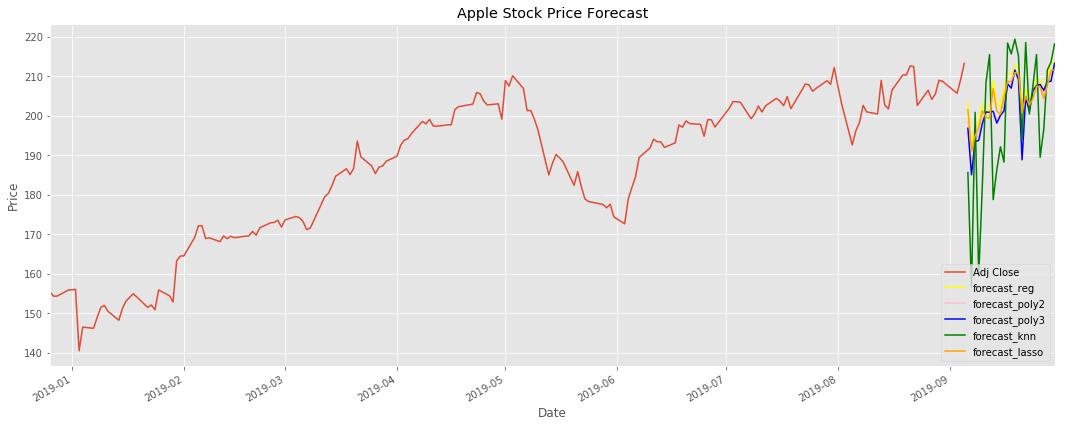

In [187]:

i = 0
for x in forecast_set_lregression:
  next_date = next_unix
  next_unix += datetime.timedelta(days=1)
  dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-5)]+[forecast_set_lregression[i]]+[forecast_set_quadregression2[i]]+[forecast_set_quadregression3[i]]+[forecast_set_knn[i]]+[forecast_set_lasso[i]]
  i += 1
  
dfreg['Adj Close'].tail(200).plot()
dfreg['forecast_reg'].tail(200).plot(color='yellow')
dfreg['forecast_poly2'].tail(200).plot(color='pink')
dfreg['forecast_poly3'].tail(200).plot(color='blue')
dfreg['forecast_knn'].tail(200).plot(color='green')
dfreg['forecast_lasso'].tail(200).plot(color='orange')

plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Apple Stock Price Forecast')
plt.show()


#Part 2 - Sentiment Analysis prediction based on tweets.
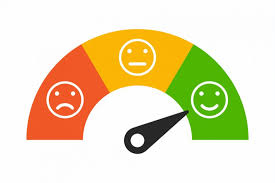

2.1: Pulling data from Tweeter. 

Getting tweets where Apple was mentioned.

In [0]:
import tweepy
from textblob import TextBlob


#---------------------------------------------------------------------------

consumer_key = ''
consumer_secret = ''

access_token = ''
access_token_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

#-------------------------------------------------------------------------



2.2 - Querying Tweets that contains Apple.

In [0]:

import time

auth = tweepy.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token, access_token_secret)

query = 'aapl -filter:retweets'
max_tweets = 50000
response_tweets = [status for status in tweepy.Cursor(api.search, q=query).items(max_tweets)]


t = []
for tweets in response_tweets:
  #enriching data with Tweepy
  created_at = datetime.datetime.strftime(tweets.created_at,'%Y-%m-%d')
  tweetid = tweets.id
  tweepy = (TextBlob(tweets.text))
  tweettext = tweets.text
  polarity = tweepy.sentiment.polarity
  subjectivity = tweepy.sentiment.subjectivity
  t.append([tweetid, created_at, tweettext ,polarity,subjectivity])


In [0]:
#converting tweets return in dataframe
labels = ['id','date','text','polarity','subjectivity']
dft = DataFrame.from_records(t, columns = labels)
#setting data as dataframe index
dft = dft.set_index('date')
#sorting dates in dataframe
dft = dft.sort_index()

end_list_date = dft.iloc[-500].name
list_size = len(dft)

#grouping and sum values for each date
df1 = dft.groupby('date').mean()


2.3 - Wraping up: Ploting Stock Price History + Forecast + Sentiment Analysis from Apple




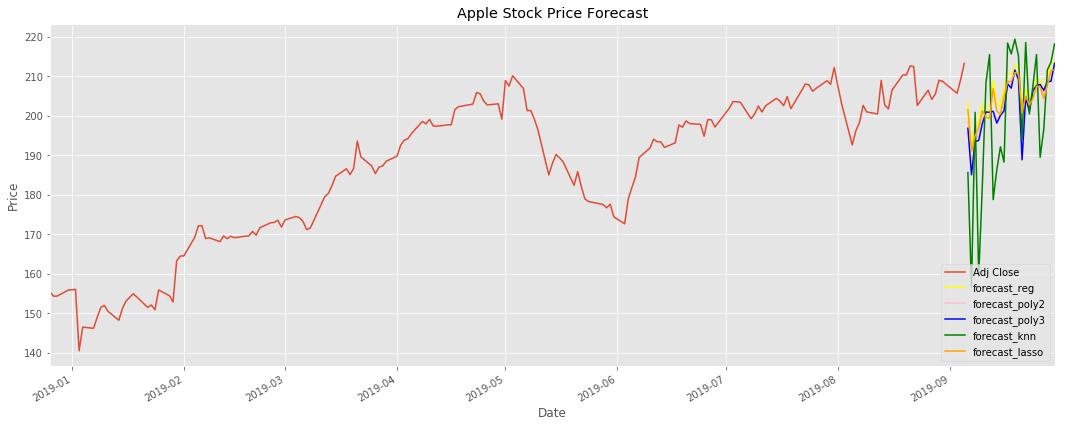

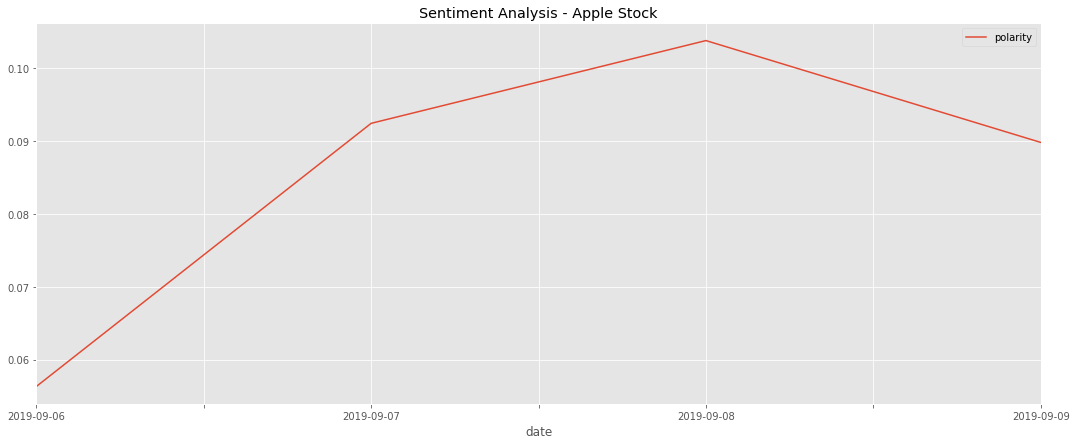

In [191]:
qty = 200
dfreg['Adj Close'].tail(qty).plot()
dfreg['forecast_reg'].tail(qty).plot(color='yellow')
dfreg['forecast_poly2'].tail(qty).plot(color='pink')
dfreg['forecast_poly3'].tail(qty).plot(color='blue')
dfreg['forecast_knn'].tail(qty).plot(color='green')
dfreg['forecast_lasso'].tail(qty).plot(color='orange')

plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Apple Stock Price Forecast')
plt.show()

df1['polarity'].plot()
plt.title('Sentiment Analysis - Apple Stock')
style.use('ggplot')
plt.legend()

#To be done:
- Filtering and removing tweets with high subjectivity
- Check if there is correlation between price and polarity variation
- Load more data from tweets (minimum 6 months) in order to understand better and observe patterns
- Implement artificial triggers to Buy and Sell stock in order to assess how good would be this model running as Trading Agent

